# **GARCH and EGarch Models**

## **0.0 Imports**

In [159]:
import pandas as pd
import yfinance as yf
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from arch import arch_model
from scipy.stats import probplot
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")

### **0.1 Load Data**

In [160]:
#Get data
ticker = yf.Ticker("USDBRL=X")


#Into df
start = '2006-01-01'
end = '2021-10-01'

df_usd = ticker.history(start=start, end = end, interval = "1d").reset_index()

#Get only close data
cols = ['Date', 'Close']
df_usd = df_usd[cols].set_index('Date')

### **0.2. Helper Function**

In [161]:

##pd.set_option('display.float_format', lambda x: '%.2f' % x)
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [13, 6]
    plt.rcParams['font.size'] = 20
    
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


### **0.3 Data Visualization**

Text(0.5, 0, 'Data')

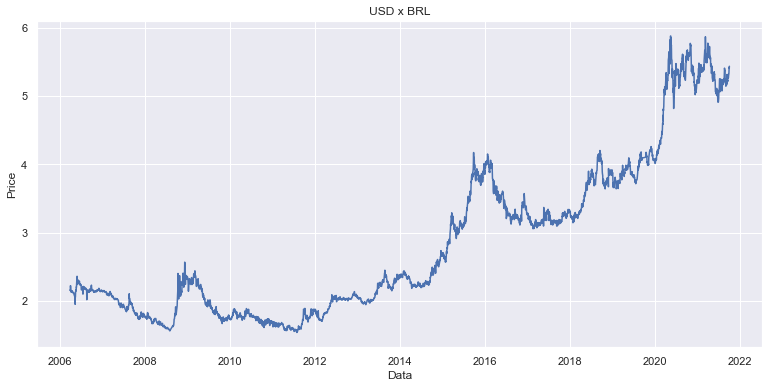

In [162]:
sns.lineplot(x = 'Date', y = 'Close', data = df_usd)
plt.title('USD x BRL')
plt.ylabel('Price')
plt.xlabel('Data')

### **0.4 Check NA**

In [163]:
df_usd.isna().sum()

Close    0
dtype: int64

# **1.0 Non-Normality Distribution of Fat Tails**    

### *The Jacque Bera is a test of whether sample data have the skewness and kurtosis matching a normal distriubtion.*

In [164]:
#Test
jarque_bera = scipy.stats.jarque_bera(df_usd['Close'])

#Test Statistic
jarque_bera.statistic

#P value
jarque_bera.pvalue


0.0

# **2.0 Serial Correlation and Unit Root**

## **2.1 PACF and ACF tests**

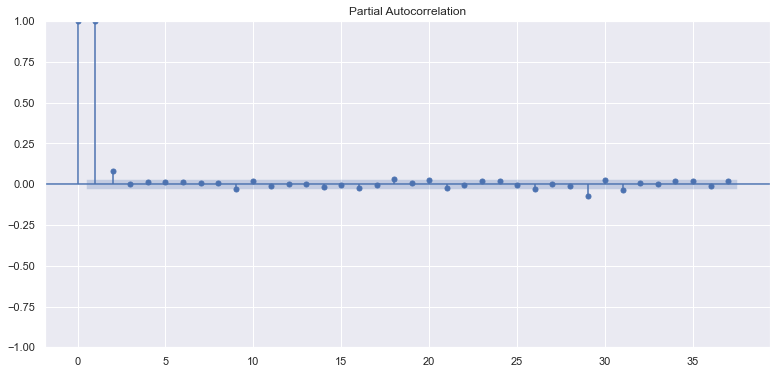

In [165]:
plot_pacf(df_usd['Close'])
plt.show()

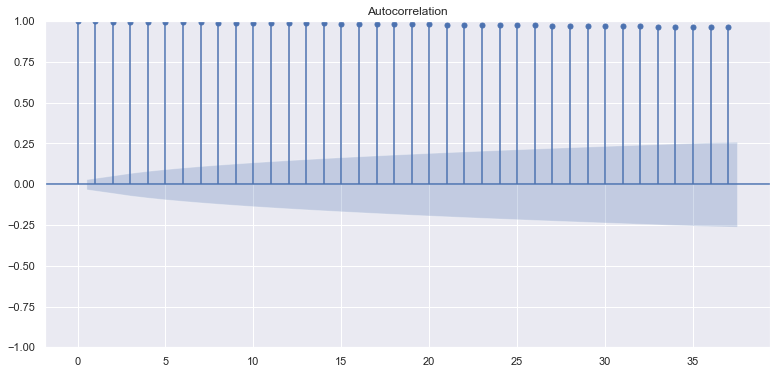

In [166]:
plot_acf(df_usd['Close'])
plt.show()

## **2.1 Stationary Tests**

### **2.1.1 Test without any differences - ADF test > -2.862 (5%): Non-stationary serie**

In [167]:
result = adfuller(df_usd['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.389599
p-value: 0.981102
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### **2.1.2 Test with one differences - ADF Test < -2.862 (5%). We have a stationary serie**

In [168]:
#Get first diff
df2 = df_usd.copy().diff()

#Dropping NA values
df2.dropna(inplace = True)

In [169]:
result_diff = adfuller(df2['Close'])
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])
print('Critical Values:')
for key, value in result_diff[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.320940
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### **2.1.3 Test without any differences - KPSS > 0.463 (5%). Non Stationary serie**

In [170]:
result_kpss = kpss(df_usd['Close'])
print('ADF Statistic: %f' % result_kpss[0])
print('p-value: %f' % result_kpss[1])
print('Critical Values:')
for key, value in result_kpss[3].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 8.118548
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


### **2.1.3 Test with one differences - KPSS <> 0.463 (5%).  Stationary serie**

In [171]:
result_diff_kpss = kpss(df2['Close'])
print('ADF Statistic: %f' % result_diff_kpss[0])
print('p-value: %f' % result_diff_kpss[1])
print('Critical Values:')
for key, value in result_diff_kpss[3].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.295388
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


# **3.0 Parametric Volatility Models**

## **3.1. The GARCH Model**


In [172]:
#Copy dataset 
df3 = df_usd.copy()

#calcuting the daily return over period
df3['return'] = 100*(df3['Close']).pct_change()


## **3.2. Plotting daily return**


Text(0.5, 0, 'Return')

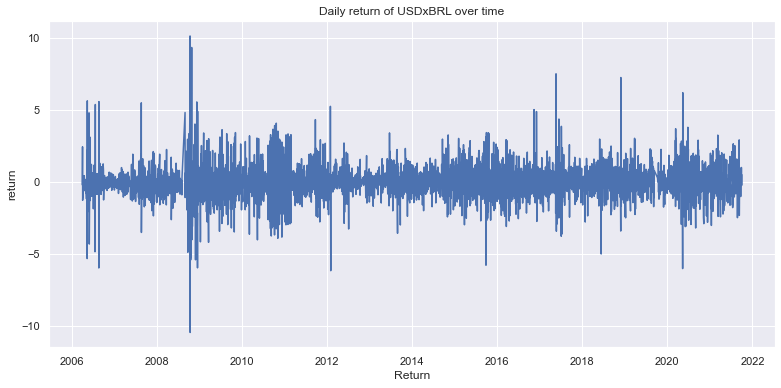

In [173]:
sns.lineplot(x = 'Date', y = 'return', data = df3);
plt.title('Daily return of USDxBRL over time')
plt.xlabel('Return')


## **3.3. Calculation of daily, monthly and annual volatility**


In [174]:
daily_volatility = df3['return'].std()
print('Daily volatility: ', '{:.2f}%'.format(daily_volatility))

monthly_volatility = math.sqrt(21) * daily_volatility
print ('Monthly volatility: ', '{:.2f}%'.format(monthly_volatility))

annual_volatility = math.sqrt(252) * daily_volatility
print ('Annual volatility: ', '{:.2f}%'.format(annual_volatility ))

Daily volatility:  1.20%
Monthly volatility:  5.52%
Annual volatility:  19.11%


## **3.4. Building a GARCH(1,1) model**


In [175]:
df3 = df_usd.copy()

#Return
df3['Return'] = 100*(df3['Close'].pct_change())
df3 = df3.dropna()

In [176]:

#Build a Garch Model

garch_model = arch_model(df3['Return'], p = 1, q=1, mean = 'constant', vol = 'GARCH', dist='normal')

gm_result = garch_model.fit(disp = 'off')
print(gm_result.params)

print('\n')


#Forecast
gm_forecast = gm_result.forecast(horizon = 5)
print(gm_forecast.variance[-1:]);

mu          0.013577
omega       0.030706
alpha[1]    0.115836
beta[1]     0.869171
Name: params, dtype: float64


                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2021-10-01  0.761343  0.780633  0.799634  0.818351  0.836787


## **3.4.0 Rolling forecast using GARCH model**


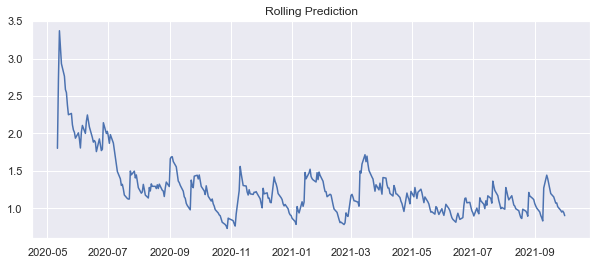

In [177]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = df3['Return'][:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=df3['Return'].index[-365:])

plt.figure(figsize=(10,4))
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')
plt.show()

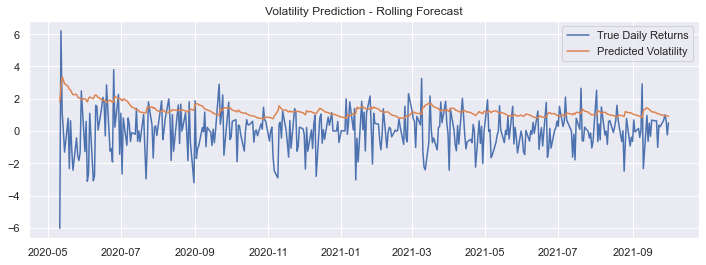

In [178]:
plt.figure(figsize=(12,4))
plt.plot(df3['Return'][-365:])
plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])
plt.show()